#### Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates


#### Read data

In [3]:
path = r"C:\Users\andre\OneDrive\Documents\AnvendtDS\consumption_temp.csv"
data = pd.read_csv(path)
data['time'] = pd.to_datetime(data['time'])

### Exploratory Data Analysis (EDA)

##### Columns
<b>Time</b>: time (in UTC), hourly values

<b>Location</b>: Biggest city in the price area, hence representative of the weather in that price area

<b>Consumption</b>: Average hourly consumption (in MW)

<b>Temperature</b>: Weather forecast for the location for that hour, available at the forecasting time (in degrees Celsius)

In [4]:
data.head()

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8


In [5]:
data.describe()

,time,consumption,temperature
count,49494,49494.000000,49494.000000
mean,2022-10-11 02:25:46.223784704,3.509242,6.554019
min,2022-04-07 21:00:00,0.000000,-17.299999
25%,2022-07-19 03:00:00,1.263256,1.000000
50%,2022-10-13 01:00:00,2.376530,6.800000
75%,2023-01-06 23:00:00,5.189000,12.100000
max,2023-04-02 21:00:00,18.045011,30.500000
std,NaN,3.096356,7.630308


#### Missing values
Helsingfors got some missing values in the dataset.

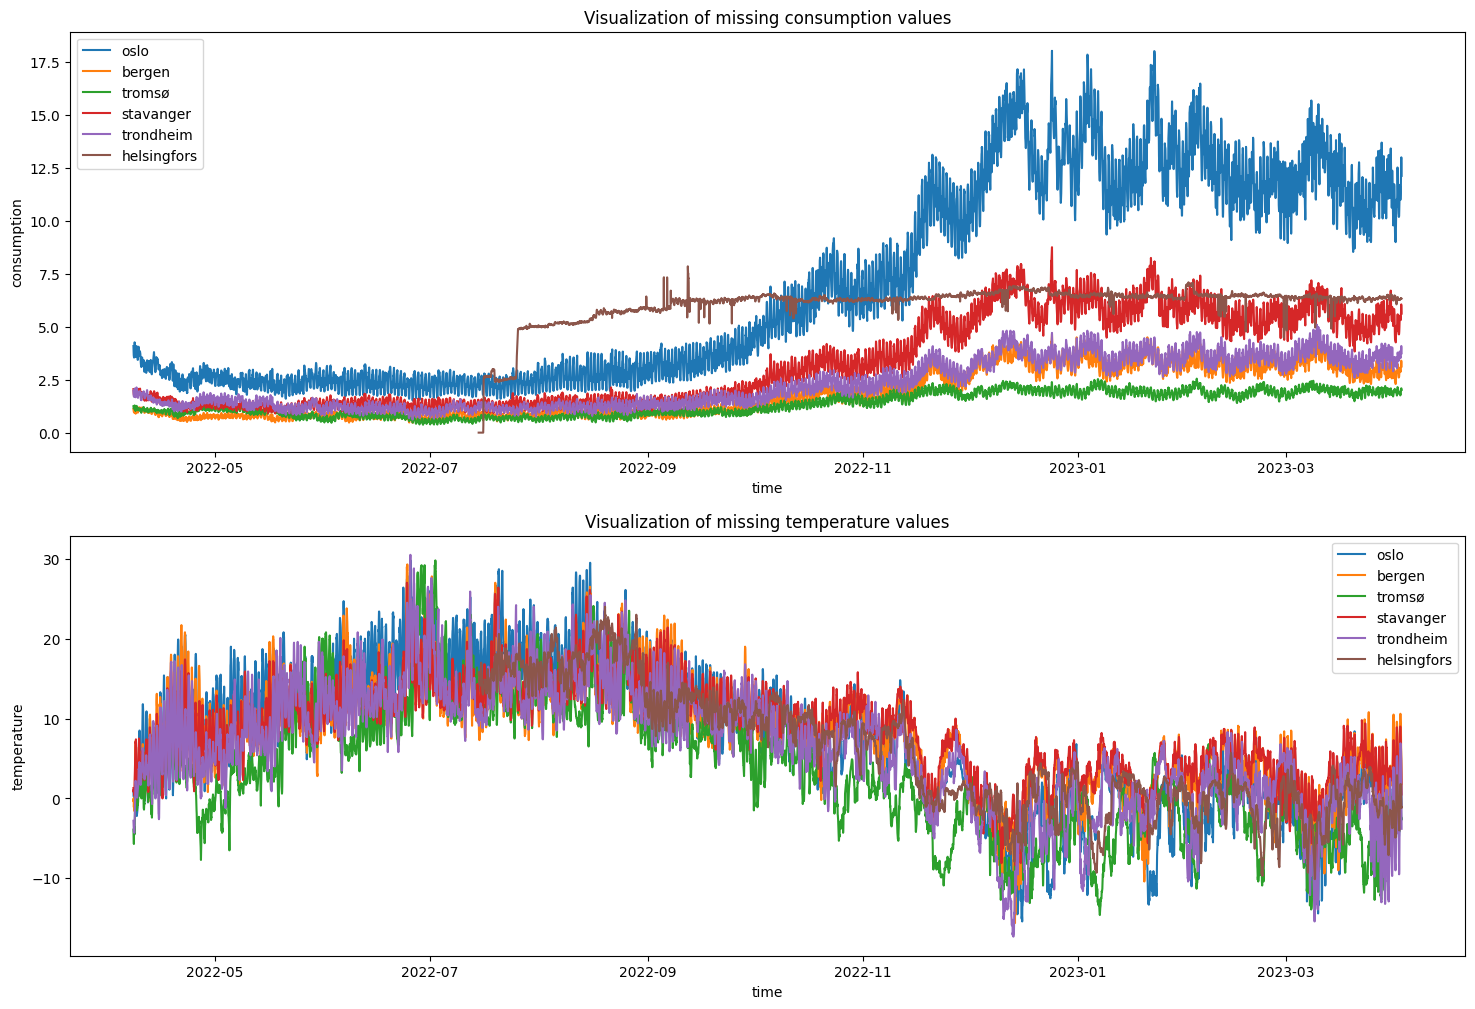

In [11]:
locations = ['oslo', 'bergen', 'tromsø', 'stavanger', 'trondheim', 'helsingfors']

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

all_times = pd.date_range(start=data['time'].min(), end=data['time'].max(), freq='H')
complete_data_df = pd.DataFrame(all_times, columns=['time'])

for location in locations:

    all_times = pd.date_range(start=data['time'].min(), end=data['time'].max(), freq='H')
    all_times_df = pd.DataFrame(all_times, columns=['time'])
    complete_location_data = all_times_df.merge(data[data['location'] == location], on='time', how='left')
    complete_data_df[f'consumption_{location}'] = complete_location_data['consumption']
    complete_data_df[f'temperature_{location}'] = complete_location_data['temperature']

    sns.lineplot(x=complete_location_data['time'], y=complete_location_data['consumption'],
                 ax=axes[0], label=location)

    sns.lineplot(x=complete_location_data['time'], y=complete_location_data['temperature'],
                 ax=axes[1], label=location)

axes[0].set_title('Visualization of missing consumption values')
axes[1].set_title('Visualization of missing temperature values')

plt.show()


<Axes: >

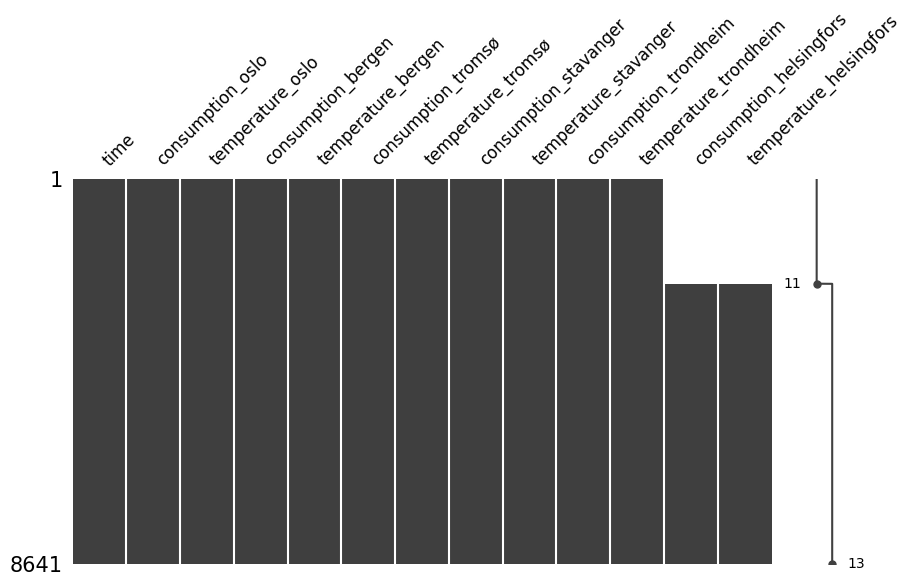

In [12]:
msno.matrix(complete_data_df, figsize=(10,5), fontsize=12)

#### Consumption and Temperature visualized

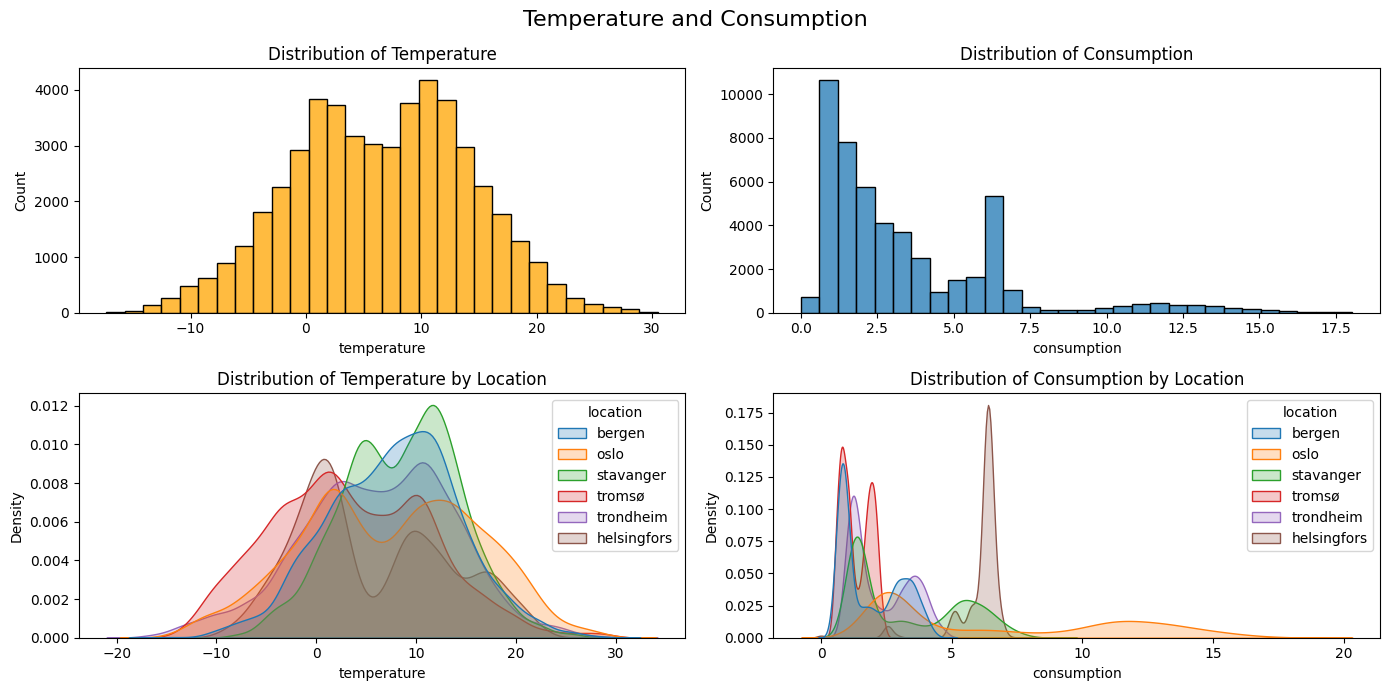

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
fig.suptitle('Temperature and Consumption', fontsize=16)

sns.histplot(data['temperature'], bins=30, ax=axes[0, 0], color='orange')
axes[0, 0].set_title('Distribution of Temperature')

sns.histplot(data['consumption'], bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Consumption')

sns.kdeplot(data=data, x="consumption", hue="location", fill=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Consumption by Location')

sns.kdeplot(data=data, x="temperature", hue="location", fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Temperature by Location')

plt.tight_layout()
plt.show()


Distribution of Consumption: Most of the values are clustered around 0-5, with a few larger values extending the tail to the right (positive skewness).

Distribution of Temperature: The temperature distribution seems to be slightly left-skewed, with most of the values occurring between approximately -5 and 25 degrees Celsius.

#### Variation with the Location

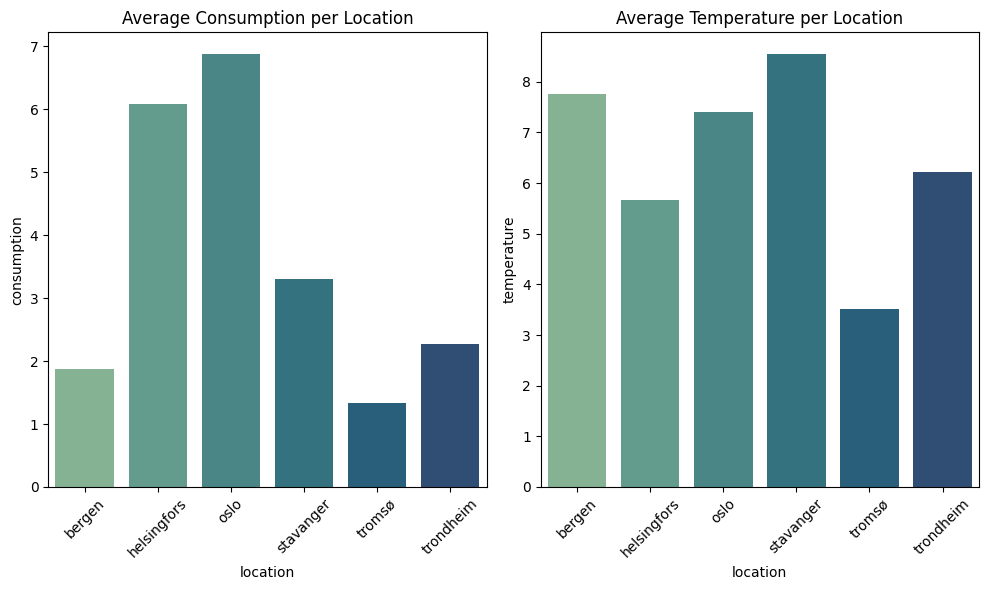

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
#fig.suptitle('Variation with Location', fontsize=16)

avg_per_location = data.groupby('location')[['consumption', 'temperature']].mean().reset_index()

sns.barplot(x='location', y='consumption', data=avg_per_location, ax=axes[0], hue='location', palette='crest')
axes[0].set_title('Average Consumption per Location')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x='location', y='temperature', data=avg_per_location, ax=axes[1], hue='location', palette='crest')
axes[1].set_title('Average Temperature per Location')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Consumption: The average consumption varies significantly among different locations.
"Oslo" tends to have the highest average consumption, while "Tromsø" tends to have the lowest.

Temperature: There is also variability in the average temperature among different locations.
"Oslo" and "Stavanger" tend to be warmer on average, while "Tromsø" tends to be cooler.

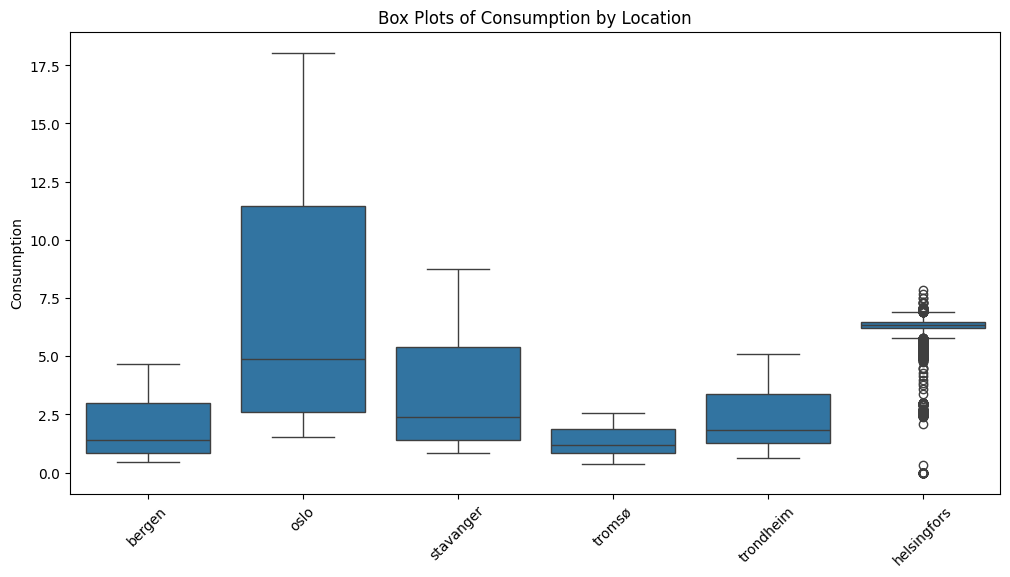

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='location', y='consumption')
plt.xlabel('')
plt.ylabel('Consumption')
plt.title('Box Plots of Consumption by Location')
plt.xticks(rotation=45)
plt.show()

#### Creating lag features and time-related features for additional analysis

In [12]:
data['time'] = pd.to_datetime(data['time'])

for lag in range(1, 31):
    data[f'consumption_lag_{lag}'] = data.groupby('location')['consumption'].shift(lag)

data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek 
data['month'] = data['time'].dt.month

# Dropping rows with NaN values due to lagging
data = data.dropna().reset_index(drop=True)

data.head()

,time,location,consumption,temperature,consumption_lag_1,consumption_lag_2,consumption_lag_3,consumption_lag_4,consumption_lag_5,consumption_lag_6,...,consumption_lag_24,consumption_lag_25,consumption_lag_26,consumption_lag_27,consumption_lag_28,consumption_lag_29,consumption_lag_30,hour,day_of_week,month
0,2022-04-09 03:00:00,bergen,0.944317,1.4,0.966941,0.966999,0.994595,1.017717,1.033282,1.080750,...,0.965054,0.977533,0.950335,0.984202,1.008794,1.050327,1.113325,3,5,4
1,2022-04-09 03:00:00,oslo,3.442056,-0.1,3.439206,3.498055,3.555068,3.698164,3.790769,3.926266,...,3.638570,3.552738,3.549536,3.584066,3.660981,3.818095,4.092830,3,5,4
2,2022-04-09 03:00:00,stavanger,1.725361,2.2,1.699743,1.716481,1.760671,1.774793,1.872067,1.911007,...,1.745010,1.753405,1.744253,1.782011,1.821749,1.918996,2.057858,3,5,4
3,2022-04-09 03:00:00,tromsø,1.079310,-0.8,1.058790,1.065904,1.080560,1.107251,1.162926,1.191047,...,1.164006,1.159867,1.140567,1.140786,1.138952,1.180321,1.246582,3,5,4
4,2022-04-09 03:00:00,trondheim,1.649036,1.1,1.664702,1.687648,1.731136,1.775228,1.844449,1.967688,...,1.752271,1.713106,1.694300,1.703176,1.747675,1.839443,1.970098,3,5,4


#### Time of the Day analysis

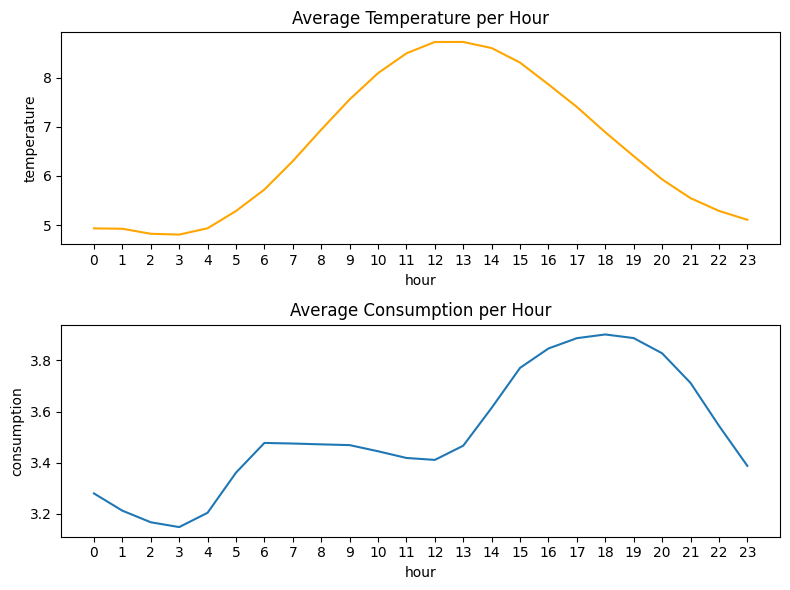

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
#fig.suptitle('Time-based Analysis', fontsize=16)

avg_hourly = data.groupby('hour')[['consumption', 'temperature']].mean().reset_index()
sns.lineplot(x='hour', y='consumption', data=avg_hourly, ax=axes[1])
axes[1].set_title('Average Consumption per Hour')
axes[1].set_xticks(range(0, 24))

sns.lineplot(x='hour', y='temperature', data=avg_hourly, ax=axes[0], color='orange')
axes[0].set_title('Average Temperature per Hour')
axes[0].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()


##### Per Hour
Consumption: It seems that there are peaks in consumption during certain hours of the day, with notable increases around 7-8 AM and 5-6 PM, which are common times for people to start and end their workdays, respectively.

Temperature: There’s a general increase in temperature during the day, peaking around midday, and a decrease during the night, which is expected due to the diurnal cycle.


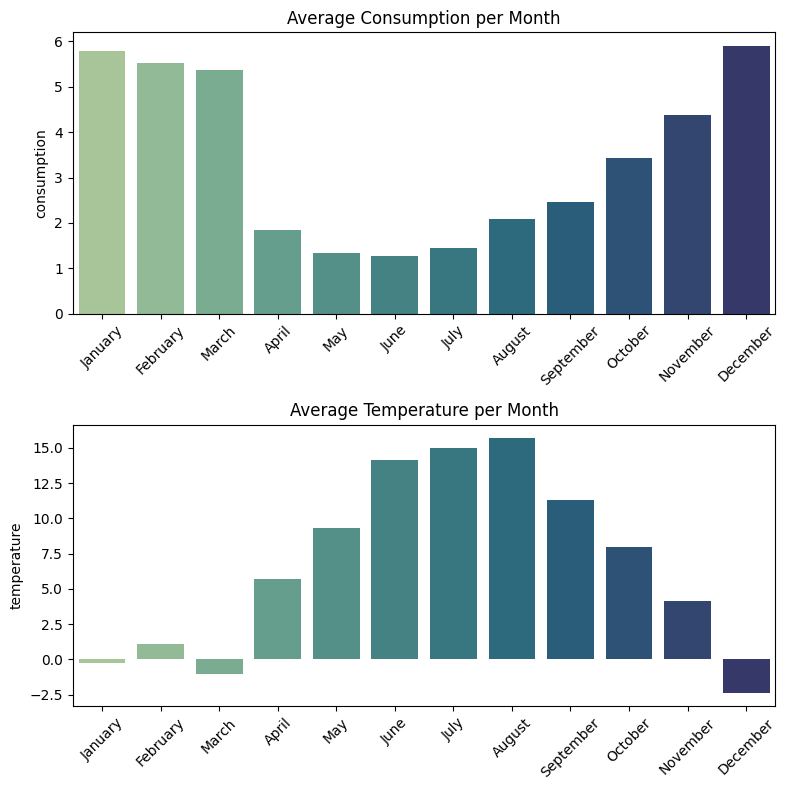

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8)) 

avg_monthly = data.groupby('month')[['consumption', 'temperature']].mean().reset_index()
order_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_mapping = {i+1: month for i, month in enumerate(order_months)}

avg_monthly['month_name'] = avg_monthly['month'].map(month_mapping)

sns.barplot(x='month_name', y='consumption', data=avg_monthly, ax=axes[0], hue='month', legend=False, palette='crest', order=order_months)
axes[0].set_title('Average Consumption per Month')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('')

sns.barplot(x='month_name', y='temperature', data=avg_monthly, ax=axes[1], hue='month', legend=False, palette='crest', order=order_months)
axes[1].set_title('Average Temperature per Month')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

##### Per Month
Consumption: There's a noticeable variation in consumption throughout the year, with peaks during the colder months (e.g., January, February) and troughs during warmer months (e.g., June, July). This might suggest a relationship between temperature and consumption, potentially due to heating usage.

Temperature: As expected, the average temperature follows a clear annual cycle, with higher temperatures in the middle of the year (summer) and lower temperatures at the start and end of the year (winter).

#### Average Consumption by Day of the Week per City

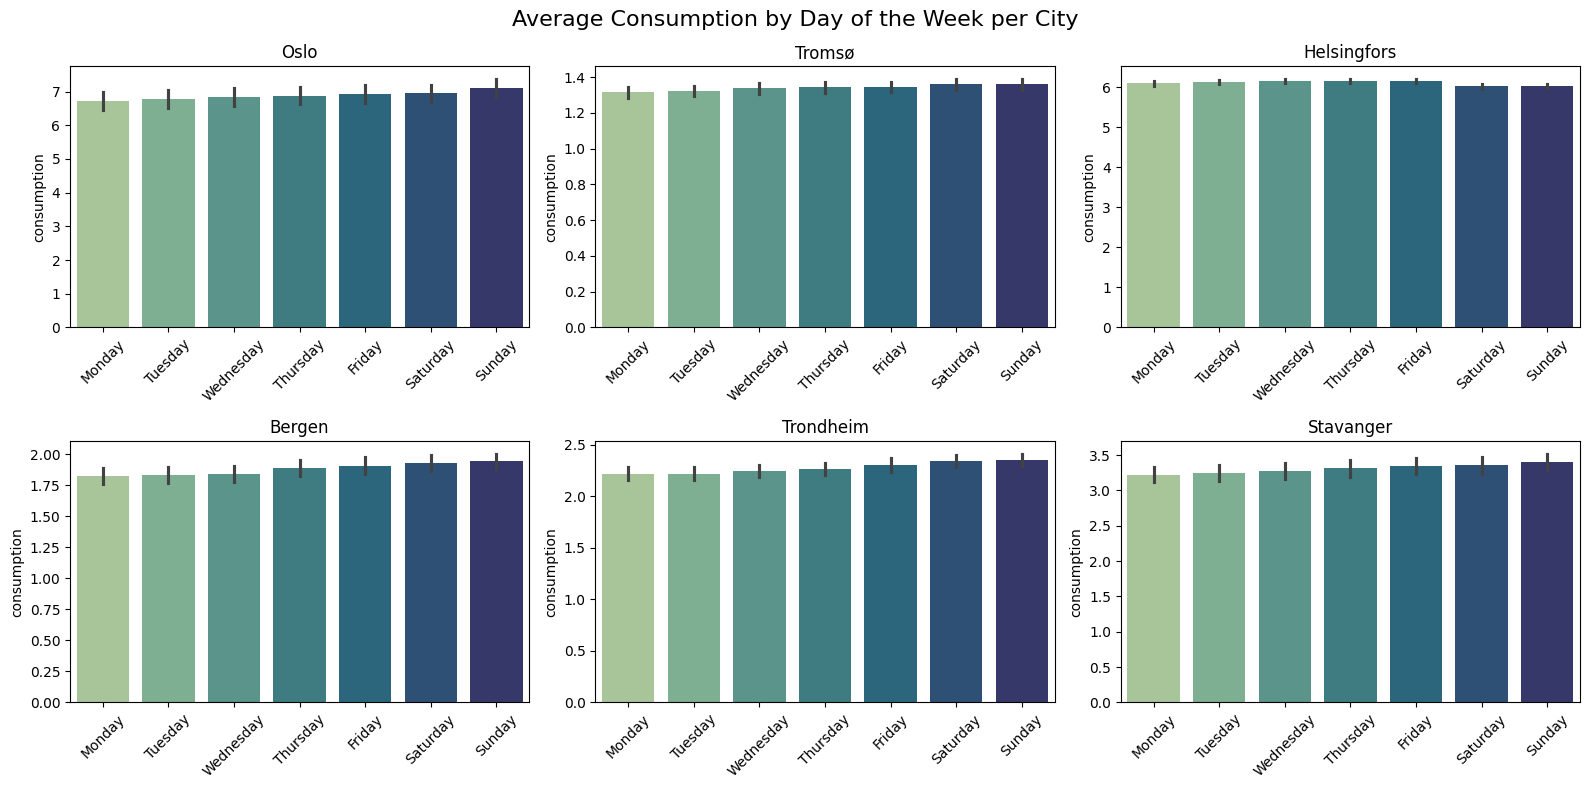

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8)) 
fig.suptitle('Average Consumption by Day of the Week per City', fontsize=16)
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.barplot(data=data[data['location'] == 'oslo'], x='day_of_week', y='consumption', palette='crest', hue='day_of_week', legend=False, ax=axes[0, 0])
axes[0, 0].set_title('Oslo')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_xticks(ticks=range(7), labels=day_labels)
axes[0, 0].set_xlabel('')

sns.barplot(data=data[data['location'] == 'bergen'], x='day_of_week', y='consumption', palette='crest', hue='day_of_week', legend=False, ax=axes[1, 0])
axes[1, 0].set_title('Bergen')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_xticks(ticks=range(7), labels=day_labels)
axes[1, 0].set_xlabel('')

sns.barplot(data=data[data['location'] == 'trondheim'], x='day_of_week', y='consumption', palette='crest', hue='day_of_week', legend=False, ax=axes[1, 1])
axes[1, 1].set_title('Trondheim')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_xticks(ticks=range(7), labels=day_labels)
axes[1, 1].set_xlabel('')

sns.barplot(data=data[data['location'] == 'tromsø'], x='day_of_week', y='consumption', palette='crest', hue='day_of_week', legend=False, ax=axes[0, 1])
axes[0, 1].set_title('Tromsø')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_xticks(ticks=range(7), labels=day_labels)
axes[0, 1].set_xlabel('')

sns.barplot(data=data[data['location'] == 'helsingfors'], x='day_of_week', y='consumption', palette='crest', hue='day_of_week', legend=False, ax=axes[0, 2])
axes[0, 2].set_title('Helsingfors')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].set_xticks(ticks=range(7), labels=day_labels)
axes[0, 2].set_xlabel('')

sns.barplot(data=data[data['location'] == 'stavanger'], x='day_of_week', y='consumption', palette='crest', hue='day_of_week', legend=False, ax=axes[1, 2])
axes[1, 2].set_title('Stavanger')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_xticks(ticks=range(7), labels=day_labels)
axes[1, 2].set_xlabel('')

plt.tight_layout()
plt.show()

##### Per Day
There doesn't appear to be a significant variation in consumption across different days of the week in the different cities.

### Lag features

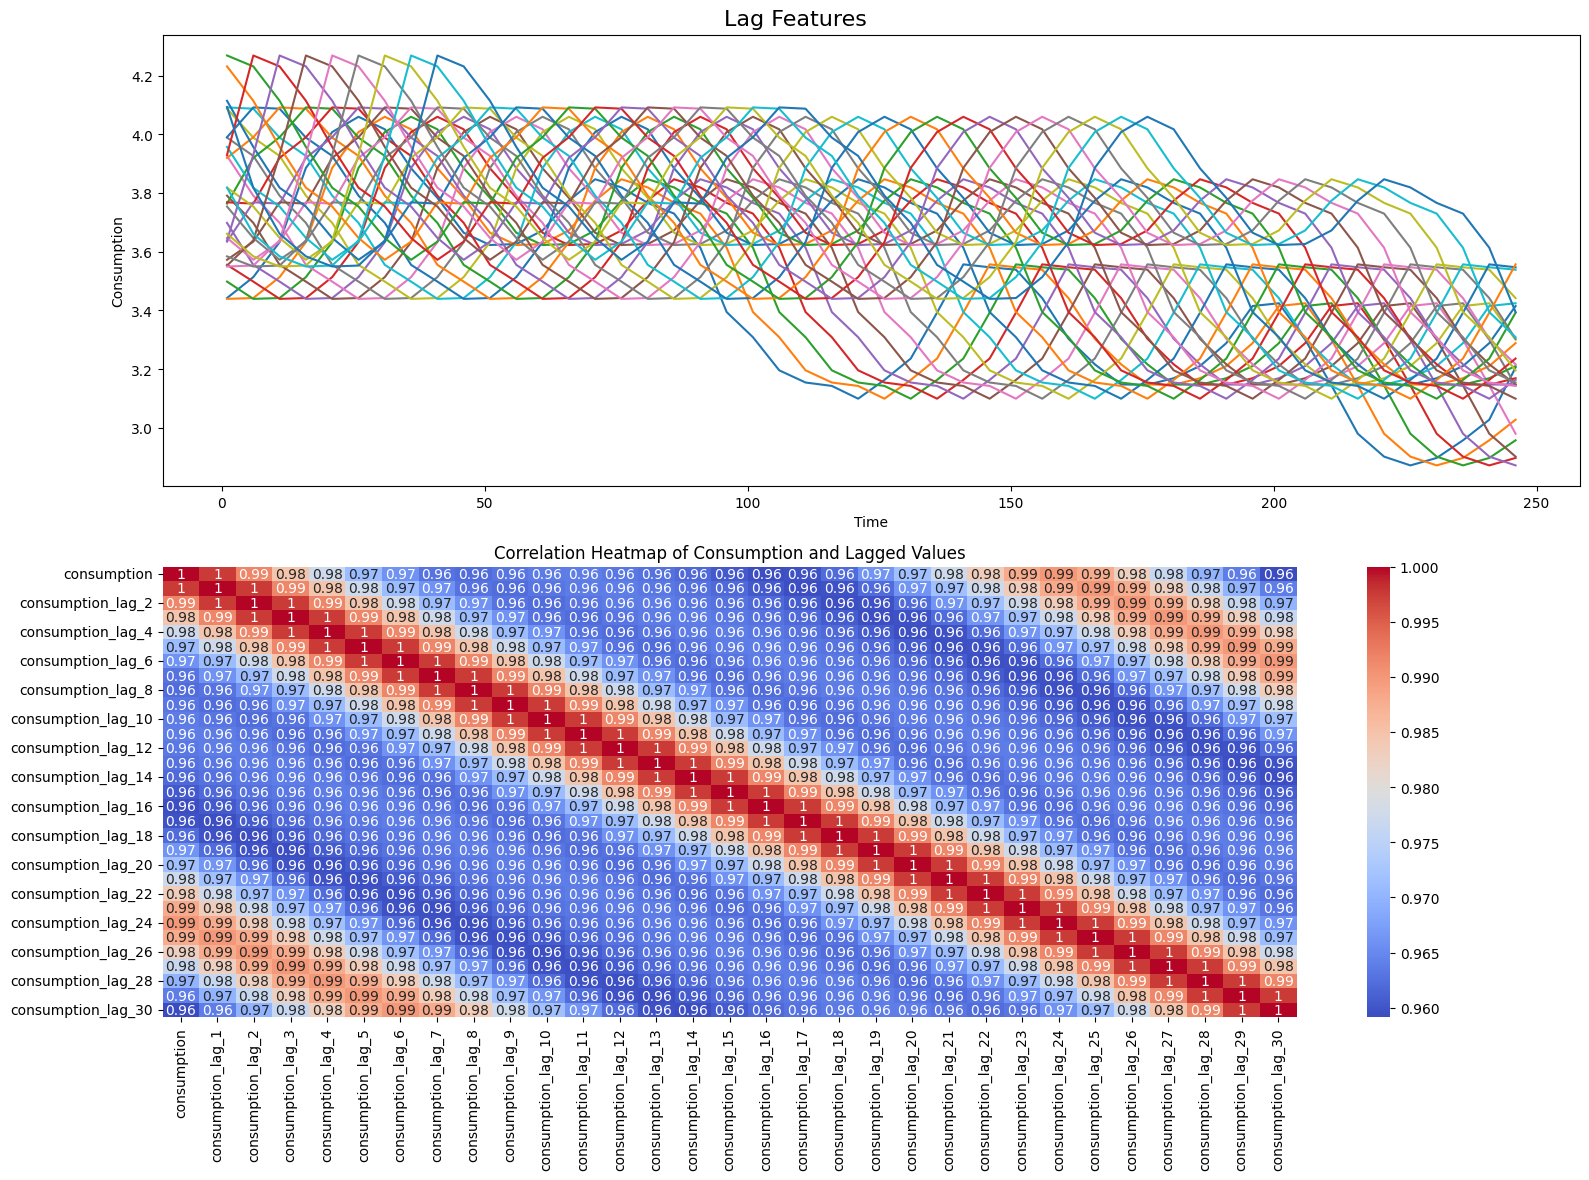

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Lag Features', fontsize=16)

data_oslo = data[data['location'] == 'oslo']

data_oslo.drop(columns=["time", "location", "temperature", "hour", "day_of_week", "month"]).head(50).plot(ax=axes[0], legend=False)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Consumption')

corr = data_oslo.drop(columns=["time", "location", "temperature", "hour", "day_of_week", "month"]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Heatmap of Consumption and Lagged Values')

plt.tight_layout()
plt.show()


Correlation Heatmap: High absolute values indicate a linear relationship with the original consumption.

In [17]:
def time_series_decomposition(location):
    data_oslo = data[data['location'] == location.lower()]
    data_oslo.set_index('time', inplace=True)
    decomposition = sm.tsa.seasonal_decompose(data_oslo['consumption'], model='additive')

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data_oslo.index, data_oslo['consumption'], label='Original')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(decomposition.trend.index, decomposition.trend, label='Trend')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(decomposition.resid.index, decomposition.resid, label='Residual')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.hist(decomposition.resid, bins=30, density=True, alpha=0.7, label='Residuals Histogram')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.suptitle(f'Time Series Decomposition for {location}', y=1.02)
    plt.show()


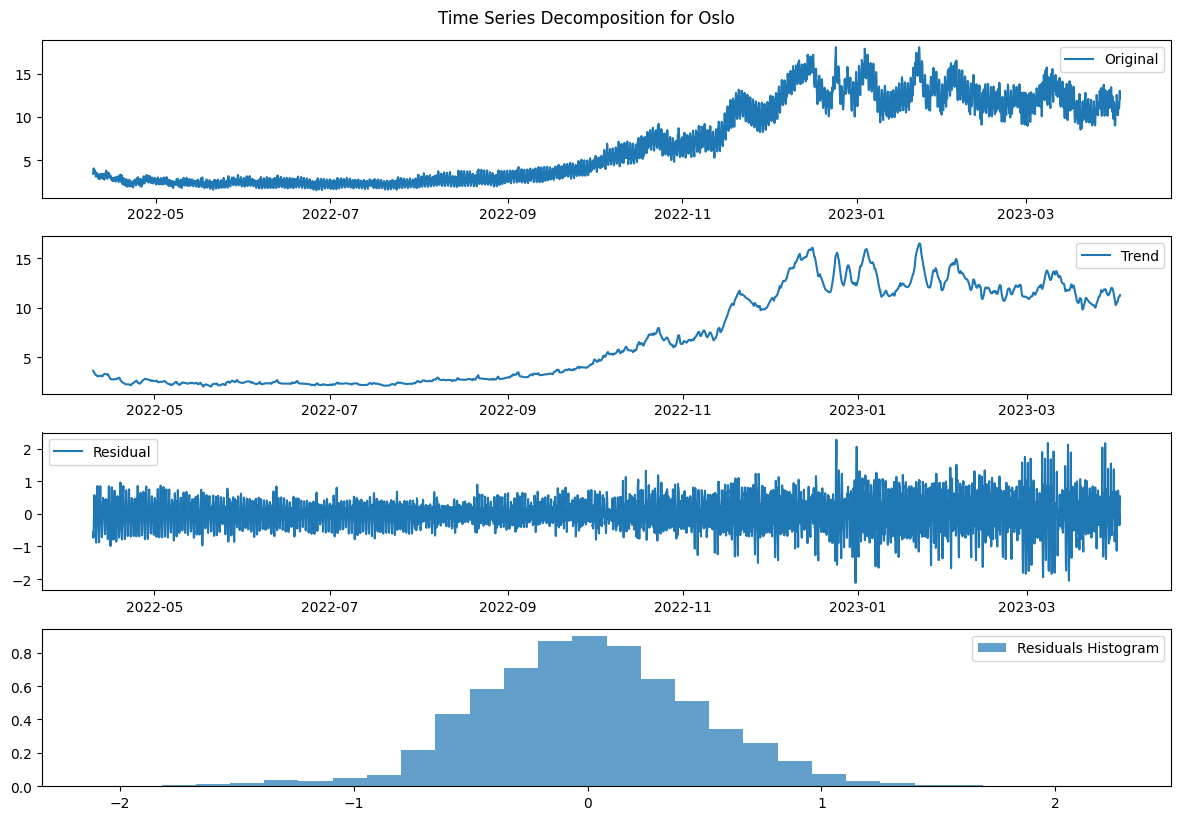

In [18]:
time_series_decomposition('Oslo')

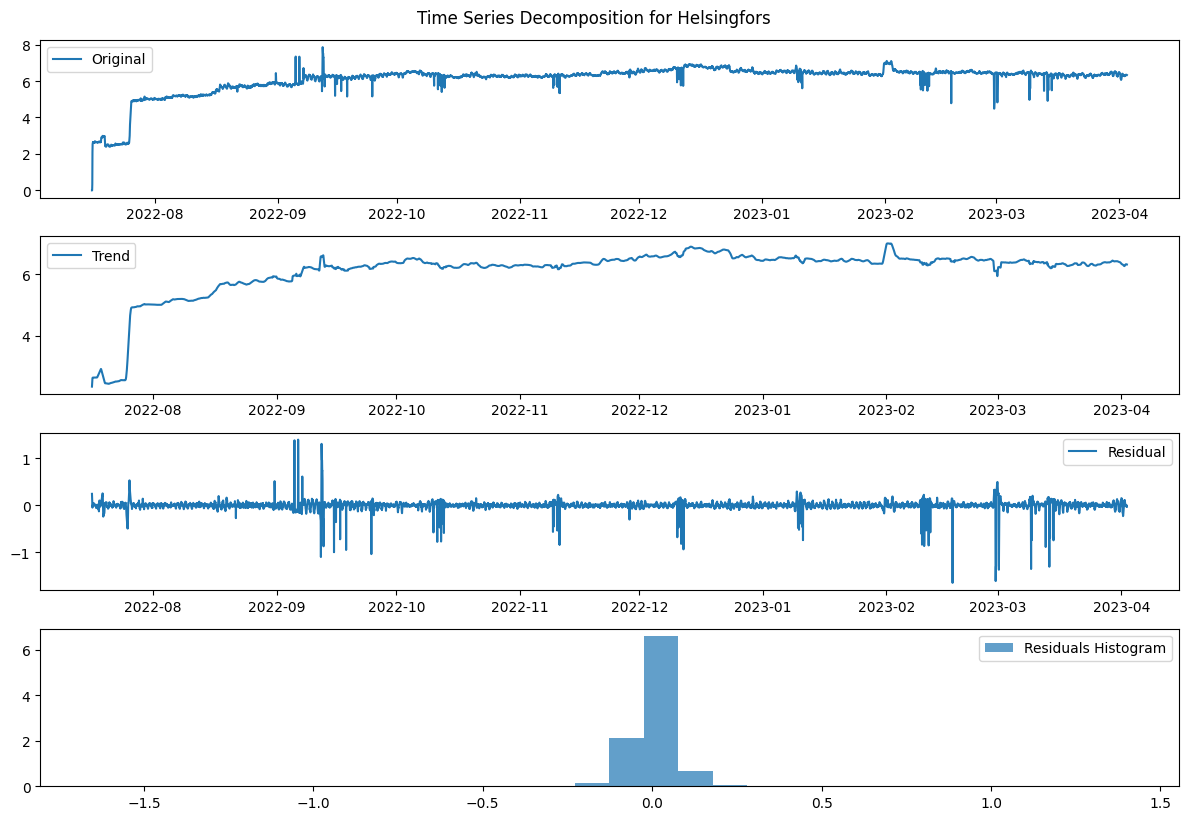

In [19]:
time_series_decomposition('Helsingfors')

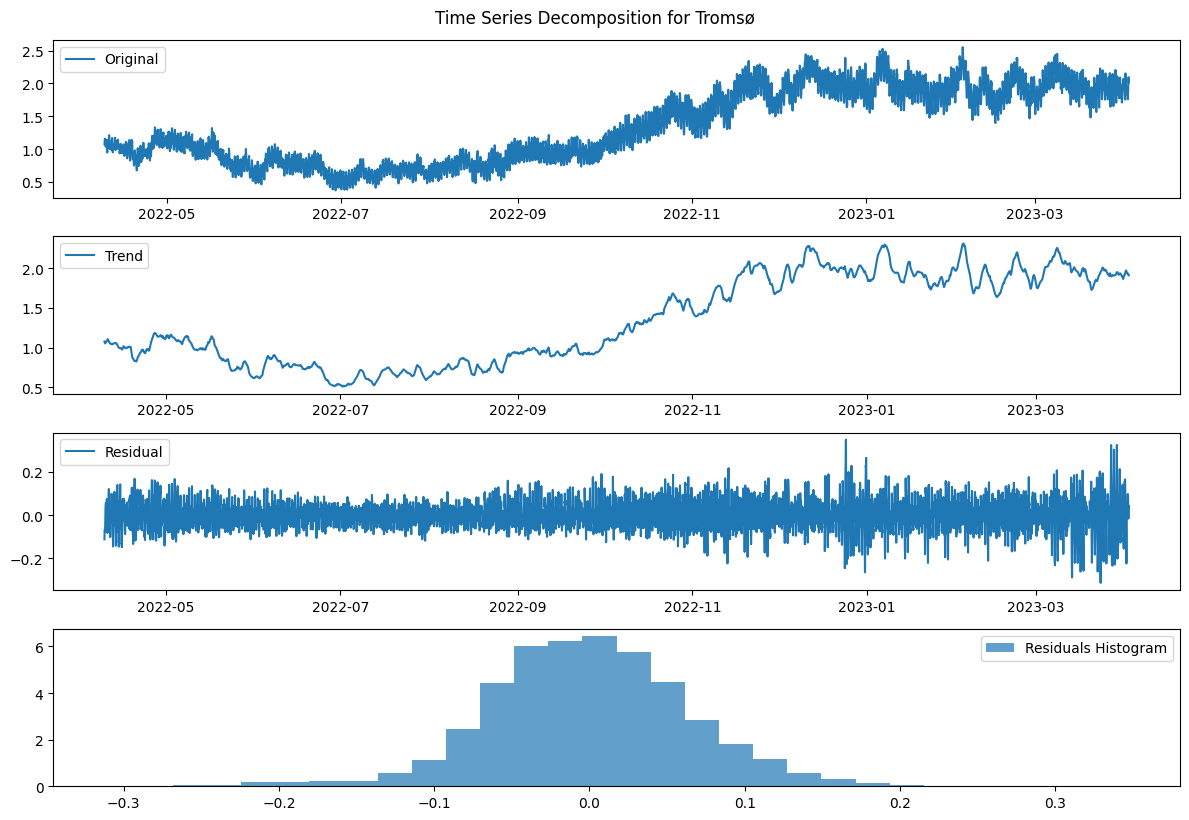

In [20]:
time_series_decomposition('Tromsø')

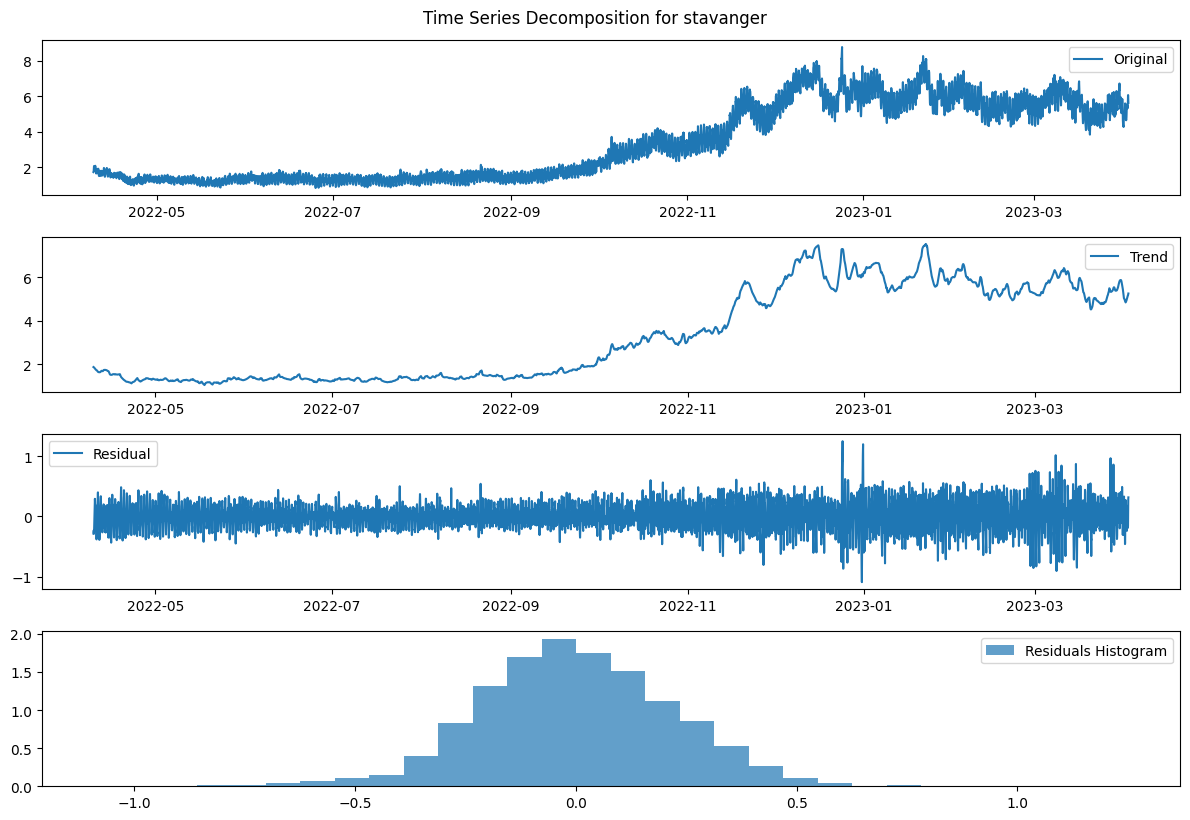

In [21]:
time_series_decomposition('stavanger')

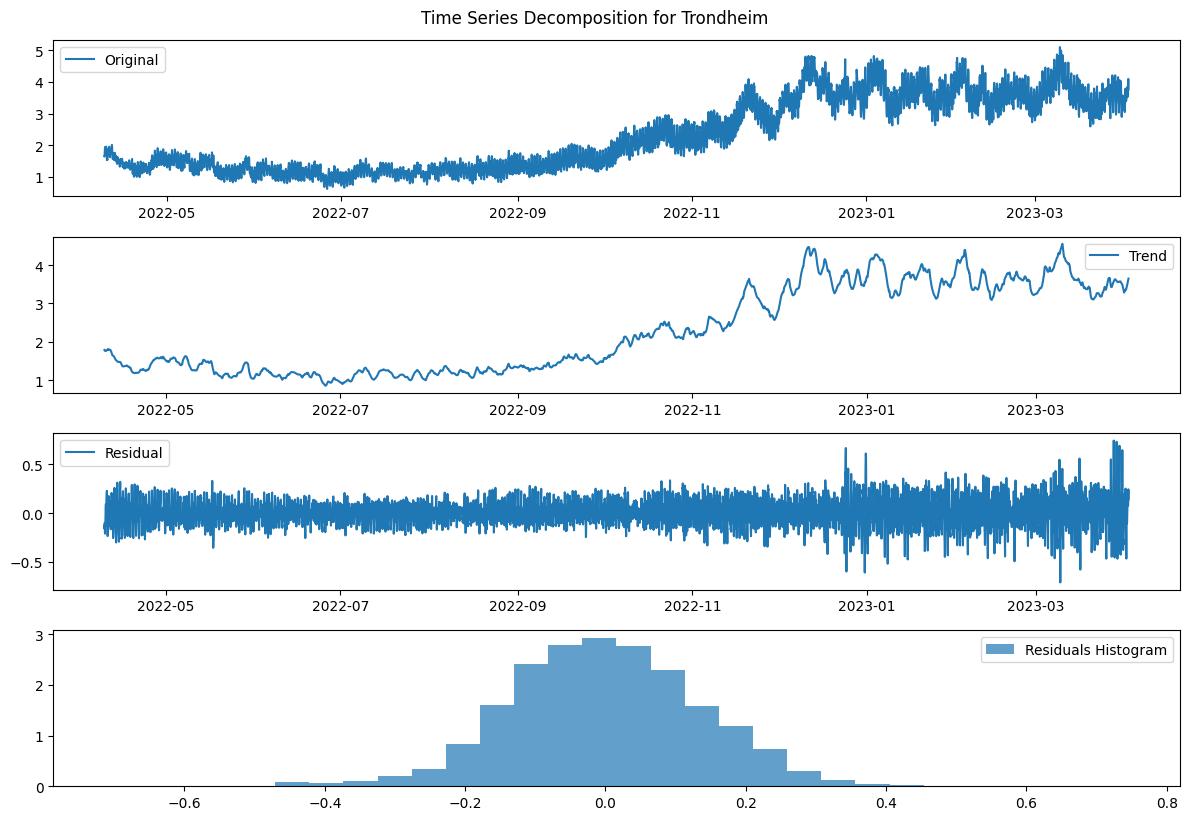

In [22]:
time_series_decomposition('Trondheim')

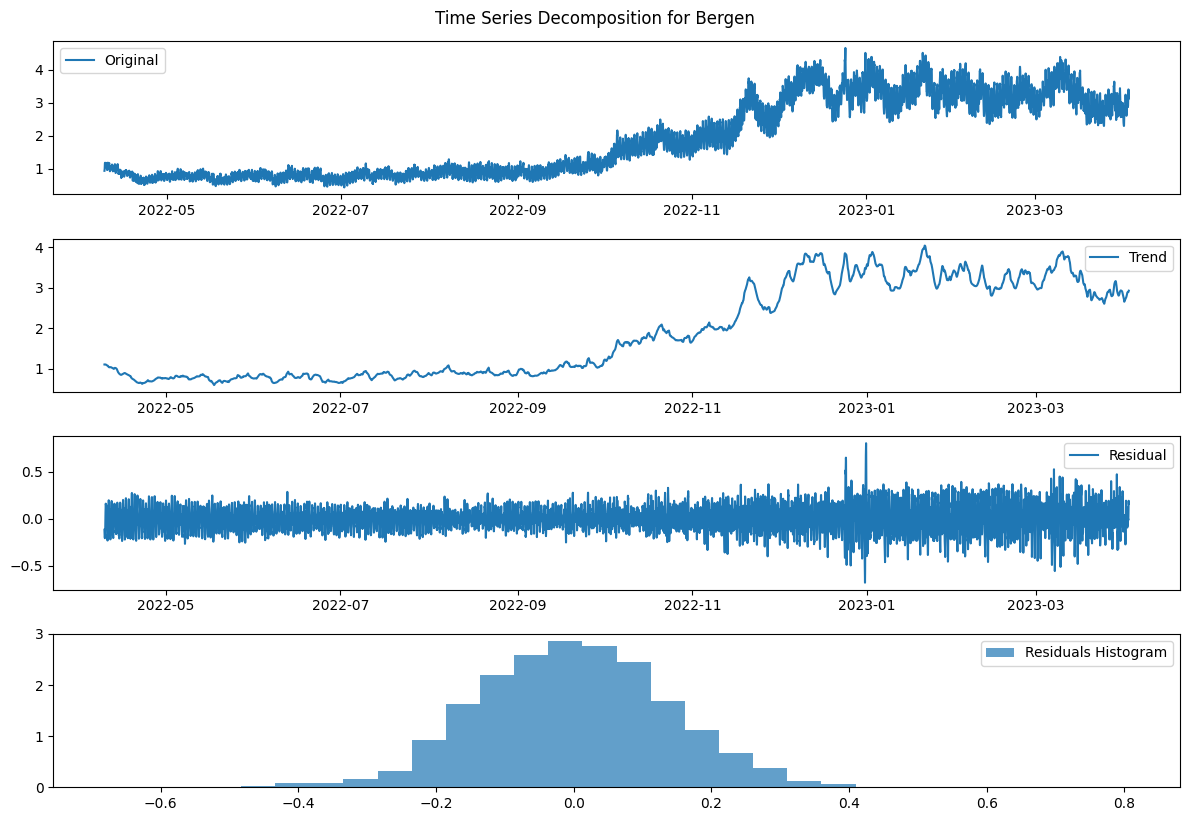

In [23]:
time_series_decomposition('Bergen')